In [42]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import time
import math
import copy
import numpy as np
import pandas as pd
import random
import itertools
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection, PolyCollection
from matplotlib.patches import Ellipse
from collections import namedtuple

!nvcc --version

import numba
from numba import cuda
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32, xoroshiro128p_normal_float32

gpu = cuda.get_current_device()
print("name = %s" % gpu.name)
print("maxThreadsPerBlock = %s" % str(gpu.MAX_THREADS_PER_BLOCK))
print("maxBlockDimX = %s" % str(gpu.MAX_BLOCK_DIM_X))
print("maxBlockDimY = %s" % str(gpu.MAX_BLOCK_DIM_Y))
print("maxBlockDimZ = %s" % str(gpu.MAX_BLOCK_DIM_Z))
print("maxGridDimX = %s" % str(gpu.MAX_GRID_DIM_X))
print("maxGridDimY = %s" % str(gpu.MAX_GRID_DIM_Y))
print("maxGridDimZ = %s" % str(gpu.MAX_GRID_DIM_Z))
print("maxSharedMemoryPerBlock = %s" % str(gpu.MAX_SHARED_MEMORY_PER_BLOCK))
print("asyncEngineCount = %s" % str(gpu.ASYNC_ENGINE_COUNT))
print("canMapHostMemory = %s" % str(gpu.CAN_MAP_HOST_MEMORY))
print("multiProcessorCount = %s" % str(gpu.MULTIPROCESSOR_COUNT))
print("warpSize = %s" % str(gpu.WARP_SIZE))
print("unifiedAddressing = %s" % str(gpu.UNIFIED_ADDRESSING))
print("pciBusID = %s" % str(gpu.PCI_BUS_ID))
print("pciDeviceID = %s" % str(gpu.PCI_DEVICE_ID))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Mon_May__3_19:15:13_PDT_2021
Cuda compilation tools, release 11.3, V11.3.109
Build cuda_11.3.r11.3/compiler.29920130_0
name = b'NVIDIA GeForce RTX 3070 Ti Laptop GPU'
maxThreadsPerBlock = 1024
maxBlockDimX = 1024
maxBlockDimY = 1024
maxBlockDimZ = 64
maxGridDimX = 2147483647
maxGridDimY = 65535
maxGridDimZ = 65535
maxSharedMemoryPerBlock = 49152
asyncEngineCount = 2
canMapHostMemory = 1
multiProcessorCount = 46
warpSize = 32
unifiedAddressing = 1
pciBusID = 1
pciDeviceID = 0


In [ ]:
# Normal unicycle model
def normalize_angle(th):
    pi_2 = 2*np.pi
    # reduce the angle  
    th =  th % pi_2; 

    # force it to be the positive remainder, so that 0 <= angle < 360  
    th = (th + pi_2) % (pi_2);  

    # force into the minimum absolute value residue class, so that -180 < angle <= 180  
    if th > np.pi:
        th -= pi_2

    return th

def normalize_angle_np(th):
    pi_2 = 2*np.pi
    # reduce the angle  
    th =  th % pi_2; 

    # force it to be the positive remainder, so that 0 <= angle < 360  
    th = (th + pi_2) % (pi_2);  

    # force into the minimum absolute value residue class, so that -180 < angle <= 180  
    mask = (th > np.pi)
    th[mask] = th[mask] - pi_2

    return th


def vis_density(ax, density, terrain, vis_cvar_alpha, color='b', title=None, hist_alpha=0.5):
    cvar, thres = density.cvar(alpha=vis_cvar_alpha)
    if density.sample_initialized:
        ax.hist(density.samples, bins=100, density=True, color=color, alpha=hist_alpha, label=terrain.name)
    ax.plot([thres, thres], [0,5], 'k--', label='{}-th Percentile'.format(int(vis_cvar_alpha*100.0)),
           linewidth=2)
    if density.sample_bounds is not None:
        ax.set_xlim(density.sample_bounds)
    if title is not None:
        ax.set_title(title)
        
        
    ax.set_xlabel("Speed (m/s)")
    ax.set_ylabel("Density")
        
    ax.legend()
    return ax

def vis_density_as_pmf(ax, density, terrain, num_bins, include_min_max=True, color='b', title=None, hist_alpha=0.5):
    values, pmf = density.get_pmf(num_bins=num_bins, include_min_max=include_min_max)
    markerline, stemlines, baseline  = ax.stem(values, pmf, label=terrain.name)
    markerline.set_color(color)
    stemlines.set_color(color)
    baseline.set_color('r')
    if density.pmf_bounds is not None:
        ax.set_xlim(density.pmf_bounds)
    if title is not None:
        ax.set_title(title)
    ax.set_xlabel("Speed (m/s)")
    ax.set_ylabel("Density")
    ax.legend()
    return ax

### Density

In [ ]:
class Density(object):
    
    def __init__(self, sample_bounds, pmf_bounds, sample_fn, num_samples=1e4):
        self.sample_bounds = sample_bounds # bound within which to sample
        self.pmf_bounds = pmf_bounds # bound within which to extract the PMF
        self.sample_fn = sample_fn
        self.num_samples = num_samples # num samples for estimating different values

        self.sample_initialized = False
        self.initialize_samples(self.num_samples)
        self.sample_initialized = False
        self.samples = None
            
    def initialize_samples(self, num_samples):
        self.samples = self.sample(num_samples)
        self.sample_initialized = True

    def mean(self, samples=None):
        if samples is not None:
            return np.mean(samples)
        else:
            if not self.sample_initialized:
                self.initialize_samples(self.num_samples)
            return np.mean(self.samples)

    def var(self, samples=None):
        if samples is not None:
            return np.var(samples)
        else:
            if not self.sample_initialized:
                self.initialize_samples(self.num_samples)
            return np.var(self.samples)
    
    def cvar(self, alpha, front=True, samples=None):
        assert alpha>0 and alpha<=1.0, "Alpha must be in (0,1]"
            
        p = alpha*100.0 if front else (1.0-alpha)*100.0
        if samples is None:
            if not self.sample_initialized:
                self.initialize_samples(self.num_samples)
            samples = self.samples

        thres = np.percentile(samples, p)
        if front:
            mask = samples<thres
        else:
            mask = samples>thres
        assert np.sum(mask)>0
        return np.mean(samples[mask]), thres
    
    def sample(self, num):
        return self.sample_fn(num)

    def get_pmf(self, num_bins, include_min_max=True):
        # For convenience, mass for min and max values are added as separate bins
        if not self.sample_initialized:
            self.initialize_samples(self.num_samples)
        vrange = self.pmf_bounds
        nums, edges = np.histogram(self.samples, num_bins, range=vrange, density=True)

        bin_width = (vrange[1]-vrange[0])/num_bins
        values = np.arange(vrange[0], vrange[1], bin_width) + bin_width/2

        if include_min_max:
            # Insert minimum value at the beginning (useful for 0 traction elements)
            values = np.insert(values, 0, vrange[0])
            nums = np.insert(nums, 0, 0)
            # Insert max value at the end (useful for nominal model that attains max values)
            values = np.append(values, vrange[1])
            nums = np.append(nums, 0)

        # Return (values, pmf)
        return values, nums/np.sum(nums)


class GaussianMixture(Density):

    def __init__(self, sample_bounds, pmf_bounds, weights, means, stds, num_samples=1e3):
        assert sum(weights)==1
        assert len(weights)==len(means)==len(stds)
        assert len(sample_bounds)==2
        assert len(pmf_bounds)==2
        assert sample_bounds[1]>=sample_bounds[0]
        assert pmf_bounds[1]>=pmf_bounds[0]
        assert pmf_bounds[0]<=sample_bounds[0] and pmf_bounds[1]>=sample_bounds[1]
        self.num_components = len(weights)
        
        def sample_fn(num):
           # Sample from mixture of Gaussian truncated between range
            num_sampled = 0
            data = []
            # indices = np.arange(len(weights))
            while num_sampled < num:
                idx = np.random.choice(self.num_components, p=weights)
                sample = np.random.normal(loc=means[idx], scale=stds[idx])
                if sample >= sample_bounds[0] and sample <= sample_bounds[1]:
                    data.append(sample)
                    num_sampled += 1 
            return np.asarray(data)
        
        super().__init__(sample_bounds, pmf_bounds, sample_fn, num_samples)

In [ ]:
# Terrain type has linear and angular traction parameters
class Terrain(object):
    def __init__(self, name, rgb, lin_density, ang_density, cvar_alpha=0.1, cvar_front=True, num_saved_samples=1e4):
        self.name = name
        self.lin_density = lin_density
        self.ang_density = ang_density
        self.num_saved_samples = num_saved_samples
        self.lin_saved_samples = self.lin_density.sample(num_saved_samples)
        self.ang_saved_samples = self.ang_density.sample(num_saved_samples)
        
        self.cvar_alpha = cvar_alpha
        self.cvar_front = cvar_front
        self.rgb = rgb
        
        # Save statistics
        self.lin_mean = self.lin_density.mean(self.lin_saved_samples)
        self.lin_var = self.lin_density.var(self.lin_saved_samples)
        self.lin_std = np.sqrt(self.lin_var)
        self.lin_cvar, self.lin_cvar_thres = self.lin_density.cvar(self.cvar_alpha, samples=self.lin_saved_samples, front=cvar_front)

        self.ang_mean = self.ang_density.mean(self.ang_saved_samples)
        self.ang_var = self.ang_density.var(self.ang_saved_samples)
        self.ang_std = np.sqrt(self.ang_var)
        self.ang_cvar, self.ang_cvar_thres = self.ang_density.cvar(self.cvar_alpha, samples=self.ang_saved_samples, front=cvar_front)

    def update_cvar_alpha(self, alpha):
        assert alpha>0 and alpha<=1.0
        self.cvar_alpha = alpha
        self.lin_cvar, self.lin_cvar_thres = self.lin_density.cvar(self.cvar_alpha, samples=self.lin_saved_samples, front=self.cvar_front)
        self.ang_cvar, self.ang_cvar_thres = self.ang_density.cvar(self.cvar_alpha, samples=self.ang_saved_samples, front=self.cvar_front)
    
    def sample_traction(self, num_samples):
        lin_samples = self.lin_density.sample(num_samples)
        ang_samples = self.ang_density.sample(num_samples)
        return lin_samples, ang_samples
    
    def __repr__(self):
        # return "Terrain {} has mean={:.2f}, std={:.2f}, cvar({:.2f})={:.2f} (computed from {} saved samples)".format(
        #     self.name, self.mean, self.std, self.cvar_alpha, self.cvar, self.num_saved_samples)
        return "Terrain {} has the following properties for linear and angular tractions.\n".format(self.name) + \
                "mean=({:.2f}, {:.2f}), std=({:.2f}, {:.2f}), cvar({:.2f})=({:.2f}, {:.2f}) (computed from {} saved samples)".format(
                    self.lin_mean, self.ang_mean, self.lin_std, self.ang_std, self.cvar_alpha, self.lin_cvar, self.ang_cvar, self.num_saved_samples
                )


"""
Traction Distribution Map (TDM) leveraging Numba to pre-allocate memory on GPU.
Internal storage is in the form of (num_bins, height, width) int8 0~100 normalized between min and max traction values (typically 0~1).
"""
num_grid_samples = 1024
class TDM_Numba(object):

    NUM_GRID_SAMPLES = num_grid_samples
    BLOCK_DIM = (1, NUM_GRID_SAMPLES)
    THREAD_DIM = (16, 16) # (32, 32)
    TOTAL_THREADS = NUM_GRID_SAMPLES*THREAD_DIM[0]*THREAD_DIM[1]

    def __init__(self, max_speed, dt):

        # Used for padding 0 traction regions around the map
        self.max_speed = max_speed
        self.dt = dt
        self.num_cells_to_pad = None


        # For initialization from semantic grid (for sim benchmarks only)
        self.semantic_grid = None # semantic_grid # semantic ids
        self.semantic_grid_initialized = False
        self.id2name = None # dict[semantic_id]=>name
        self.name2terrain = None # dict[name]=>Terrain object
        self.id2terrain_fn = None
        self.terrain2pmf = None

        # Set the properties for pmf_grid.
        # For now, assume all pmf has the same range
        self.pmf_grid = None
        self.bin_values = None
        self.bin_values_bounds = None
        self.pmf_grid_d = None # data on device
        self.bin_values_d = None
        self.bin_values_bounds_d = None
        self.num_pmf_bins = None
        self.num_cols = None
        self.num_rows = None
        self.padded_num_cols = None
        self.padded_num_rows = None
        self.xlimits = None
        self.ylimits = None
        self.padded_xlimits = None
        self.padded_ylimits = None
        self.pad_width = None
        self.res = None
        self.pmf_grid_initialized = False

        # Initialize batch_sample variables
        self.sample_grid_batch_d = None
        self.rng_states_d = None
        self.device_var_initialized = False

        # For visualization
        self.cell_dimensions = None
        self.figsize = None

    def set_TDM_from_semantic_grid(self, sg, res, num_pmf_bins, bin_values, bin_values_bounds,
                                  xlimits, ylimits, id2name, name2terrain, terrain2pmf):
        """
        Save semantic grid and initialize visualization parameters.
        initialize the PMF grid and copy to device. 
        Return: (pmf_grid, pmf_grid_d)
        """
        # Based on semantics, construct the grid 
        self.semantic_grid = sg.copy()
        self.id2name = id2name # dict[semantic_id]=>name
        self.name2terrain = name2terrain # dict[name]=>Terrain object
        self.id2terrain_fn = lambda semantic_id: self.name2terrain[self.id2name[semantic_id]]
        self.terrain2pmf = terrain2pmf
        self.semantic_grid_initialized = True
        self.cell_dimensions = (res, res)
        self.xlimits = xlimits
        self.ylimits = ylimits
        self.num_rows, self.num_cols = sg.shape
        self.num_pmf_bins = num_pmf_bins
        self.bin_values = np.asarray(bin_values).astype(np.float32)
        self.bin_values_bounds = np.asarray(bin_values_bounds).astype(np.float32)
        self.res = res
        assert bin_values[0]==0, "Assume minimum bin value is 0 for now"
        assert bin_values_bounds[0]==0, "Assume minimum traction is 0 for now"
        

        # Initialize pmf grid
        # Account for padding
        self.pmf_grid = np.zeros((self.num_pmf_bins, self.num_rows, self.num_cols), dtype=np.int8)
        for ri in range(self.num_rows):
            for ci in range(self.num_cols):
                terrain = self.id2terrain_fn(self.semantic_grid[ri, ci])
                values, pmf = self.terrain2pmf[terrain]
                self.pmf_grid[:, ri, ci] = np.rint(pmf*100).astype(np.int8)
                # Make sure cum sum is 100
                self.pmf_grid[-1, ri, ci] = np.int8(100)-np.sum(self.pmf_grid[:-1, ri, ci])
        
        padded_pmf_grid, padded_xlimits, padded_ylimits = self.set_padding(self.pmf_grid, self.max_speed, self.dt, res,
                                                            xlimits, ylimits)
        self.pmf_grid_d = cuda.to_device(padded_pmf_grid)
        self.padded_xlimits = padded_xlimits
        self.padded_ylimits = padded_ylimits
        _, self.padded_num_cols, self.padded_num_rows = padded_pmf_grid.shape
        self.bin_values_d = cuda.to_device(bin_values)
        self.bin_values_bounds_d = cuda.to_device(bin_values_bounds)
        self.pmf_grid_initialized = True

        
    def set_TDM_from_PMF_grid(self, pmf_grid, res, xlimits, ylimits, bin_values, bin_values_bounds):
        # TODO: make sure parameters are all set properly


        assert len(pmf_grid.shape)==3, "PMF grid must have 3 dimensions"
        self.num_pmf_bins, self.num_rows, self.num_cols = pmf_grid.shape
        self.cell_dimensions = (res, res)
        self.xlimits = xlimits
        self.ylimits = ylimits

        self.pmf_grid = np.asarray(pmf_grid).astype(np.int8)
        self.bin_values = np.asarray(bin_values).astype(np.float32)
        self.bin_values_bounds = np.asarray(bin_values_bounds).astype(np.float32)
        assert bin_values[0]==0, "Assume minimum bin value is 0 for now"
        assert bin_values_bounds[0]==0, "Assume minimum traction is 0 for now"
        # self.pmf_grid_d = cuda.to_device(self.pmf_grid)
        self.bin_values_d = cuda.to_device(bin_values)
        self.bin_values_bounds_d = cuda.to_device(bin_values_bounds)
        self.res = res

        padded_pmf_grid, padded_xlimits, padded_ylimits = self.set_padding(self.pmf_grid, self.max_speed, self.dt, res,
                                                            xlimits, ylimits)

        self.pmf_grid_d = cuda.to_device(padded_pmf_grid)
        self.padded_xlimits = padded_xlimits
        self.padded_ylimits = padded_ylimits
        _, self.padded_num_rows, self.padded_num_cols = padded_pmf_grid.shape
        self.pmf_grid_initialized = True 

        

    def set_padding(self, pmf_grid, max_speed, dt, res, xlimits, ylimits):
        # Padd the nominal pmf grid with 0_traction components (assumed to be the first bin values)
        _, original_height, original_width = pmf_grid.shape
        self.pad_width = pad_width = int(np.ceil(max_speed*dt/res))
        self.padded_num_cols = self.num_cols+2*pad_width
        self.padded_num_rows = self.num_rows+2*pad_width
        padded_xlimits = np.array([xlimits[0]-pad_width*res, xlimits[0]+pad_width*res])
        padded_ylimits = np.array([ylimits[0]-pad_width*res, ylimits[0]+pad_width*res])

        padded_pmf_grid = np.zeros((self.num_pmf_bins, original_height+int(2*pad_width), original_width+int(2*pad_width)), dtype=np.int8)
        padded_pmf_grid[0] = 100 # Fill the probability mass associated with 0 traction
        padded_pmf_grid[:, pad_width:(pad_width+original_height), pad_width:(pad_width+original_width)] = pmf_grid
        
        return padded_pmf_grid, padded_xlimits, padded_ylimits


    def init_device_vars_before_sampling(self, seed=1):
        # num_samples = number of grids
        if not self.device_var_initialized:
            _, rows, cols = self.pmf_grid_d.shape
            self.rng_states_d = create_xoroshiro128p_states(self.TOTAL_THREADS, seed=seed)
            self.sample_grid_batch_d = cuda.device_array((self.NUM_GRID_SAMPLES, rows, cols), dtype=np.int8)
            self.device_var_initialized = True
    
    def sample_grids(self):
        # Invoke the GPU kernels
        self.sample_grids_numba[self.BLOCK_DIM, self.THREAD_DIM](
            self.sample_grid_batch_d, self.pmf_grid_d, self.rng_states_d,
            self.bin_values_d, self.bin_values_bounds_d
        )
        return self.sample_grid_batch_d


    def int8_grid_to_float32(self, int8grid):
        # int8 value between 0 and 100 represent some value within bin_values_bounds
        ratio = np.asarray(int8grid.copy()).astype(np.float32)/100.
        return ratio*(self.bin_values_bounds[1]-self.bin_values_bounds[0])+self.bin_values_bounds[0]

    @staticmethod
    @cuda.jit(fastmath=True)
    def sample_grids_numba(grid_batch_d, pmf_grid_d, rng_states_d,
                     bin_values_d, bin_values_bounds_d):
        # Each 2D block samples a single grid
        # Only consider a single row of block (1, num_blocks)
        # Every thread takes care of a small section of the grid
        # Return a reference to sampled grids on GPU

        threads_x = cuda.blockDim.x # row
        threads_y = cuda.blockDim.y # col
        blocks_x = cuda.gridDim.x # row
        blocks_y = cuda.gridDim.y # col
        num_bins, grid_rows, grid_cols = pmf_grid_d.shape
        num_col_entries_per_thread = math.ceil(grid_cols/threads_y)
        num_rows_entries_per_thread = math.ceil(grid_rows/threads_x)
        
        # thread info
        block_id = cuda.blockIdx.y#
        tid_x = cuda.threadIdx.x # index within block
        tid_y = cuda.threadIdx.y # index within block
        abs_tid_x, abs_tid_y = cuda.grid(2) # absolute x, y index
        thread_id = abs_tid_x*threads_y*blocks_y + abs_tid_y
        # print(thread_id)
        # cuda.syncthreads()

        # Compute horizontal and vertical index range
        ri_start = min(tid_x*num_rows_entries_per_thread, grid_rows)
        ri_end = min(ri_start+num_rows_entries_per_thread, grid_rows)
        ci_start = min(tid_y*num_col_entries_per_thread, grid_cols)
        ci_end = min(ci_start+num_col_entries_per_thread, grid_cols)

        traction_range = bin_values_bounds_d[1]-bin_values_bounds_d[0]
        cum_pmf = np.int8(0)
        sampled_cum_pmf = np.int8(8)
        for ri in range(ri_start, ri_end):
            for ci in range(ci_start, ci_end):
                # Check which bin this belongs to
                rand_num = xoroshiro128p_uniform_float32(rng_states_d, thread_id)
                sampled_cum_pmf = rand_num*100.0
                cum_pmf = 0
                for bi in range(num_bins):
                    cum_pmf += pmf_grid_d[bi, ri, ci]
                    if sampled_cum_pmf <= cum_pmf:
                        grid_batch_d[block_id, ri, ci] = np.int8(100.*(bin_values_d[bi]-bin_values_bounds_d[0])/traction_range)
                        if grid_batch_d[block_id, ri, ci]<0:
                            print("<0")
                        break
        cuda.syncthreads()

class TDM_Visualizer(object):


    PREFERRED_MAX_FIG_WIDTH = 12
    PREFERRED_MAX_FIG_HEIGHT = 8

    def __init__(self, tdm):
        self.semantic_grid_initialized = tdm.semantic_grid_initialized
        self.num_rows = tdm.padded_num_rows
        self.num_cols = tdm.padded_num_cols
        self.ylimits = copy.deepcopy(tdm.ylimits)
        self.xlimits = copy.deepcopy(tdm.xlimits)

        self.semantic_grid = copy.deepcopy(tdm.semantic_grid)
        self.id2name = copy.deepcopy(tdm.id2name)
        self.name2terrain = copy.deepcopy(tdm.name2terrain)
        self.id2terrain_fn = copy.deepcopy(tdm.id2terrain_fn)
        self.id2rgb = {sid: self.id2terrain_fn(sid).rgb for sid in self.id2name}
        self.terrain2pmf = copy.deepcopy(tdm.terrain2pmf)
        self.semantic_grid_initialized = tdm.semantic_grid_initialized
        self.cell_dimensions = copy.deepcopy(tdm.cell_dimensions)
        self.xlimits = copy.deepcopy(tdm.padded_xlimits)
        self.ylimits = copy.deepcopy(tdm.padded_ylimits)
        self.num_pmf_bins = copy.deepcopy(tdm.num_pmf_bins)
        self.bin_values = copy.deepcopy(tdm.bin_values)
        self.bin_values_bounds = copy.deepcopy(tdm.bin_values_bounds)
        
        # If padded, create new semantic_grid and update color (using black?)
        self.pad_width = tdm.pad_width
        self.id2name[-1] = "Padding"
        self.id2rgb[-1] = (0,0,0,)

        original_semantic_grid = copy.deepcopy(self.semantic_grid)
        self.semantic_grid = -1*np.ones((self.num_rows, self.num_cols))
        self.semantic_grid[self.pad_width:(self.num_rows-self.pad_width), self.pad_width:(self.num_cols-self.pad_width)] = original_semantic_grid
            

    def draw(self, figsize=(10,10)):
        if not self.semantic_grid_initialized:
            print("Semantic grid not initialized. Cannot invoke draw() function")
            return

        if figsize is None:
            self.figsize = self.calc_auto_figsize(self.xlimits, self.ylimits)
            fig, ax = self.draw_base_grid(self.figsize)
        else:
            fig, ax = self.draw_base_grid(figsize)

        if self.semantic_grid_initialized:
            self.draw_semantic_patches(ax)
        else:
            print("Colors not shown as semantic grid is not initialized.")
        return fig, ax
    
    def draw_base_grid(self, figsize):
        cols, rows = self.num_cols, self.num_rows
        minx, maxx = self.xlimits
        miny, maxy = self.ylimits

        width, height = self.cell_dimensions

        x = list(map(lambda i: minx + width*i, range(cols+1)))
        y = list(map(lambda i: miny + height*i, range(rows+1)))

        fig = plt.figure(figsize=figsize)

        hlines = np.column_stack(np.broadcast_arrays(x[0], y, x[-1], y))
        vlines = np.column_stack(np.broadcast_arrays(x, y[0], x, y[-1]))
        lines = np.concatenate([hlines, vlines]).reshape(-1, 2, 2)
        line_collection = LineCollection(lines, color="black", linewidths=0.5)
        ax = plt.gca()
        ax.add_collection(line_collection)
        ax.set_xlim(x[0]-1, x[-1]+1)
        ax.set_ylim(y[0]-1, y[-1]+1)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.axis('off')

        return fig, plt.gca()

    def calc_auto_figsize(self, xlimits, ylimits):
        (minx, maxx) = xlimits
        (miny, maxy) = ylimits
        width, height = maxx - minx, maxy - miny
        if width > height:
            figsize = (self.PREFERRED_MAX_FIG_WIDTH, height * self.PREFERRED_MAX_FIG_WIDTH / width)
        else:
            figsize = (width * self.PREFERRED_MAX_FIG_HEIGHT / height, self.PREFERRED_MAX_FIG_HEIGHT)
        return figsize

    def cell_verts(self, ix, iy):
        width, height = self.cell_dimensions
        x, y = self.cell_xy(ix, iy)
        verts = [(x + ofx*0.5*width, y + ofy*0.5*height) for ofx, ofy in [(-1,-1),(-1,1),(1,1),(1,-1)]]
        return verts

    def cell_xy(self, ix, iy):
        """Returns the center xy point of the cell."""
        minx, maxx = self.xlimits
        miny, maxy = self.ylimits
        width, height = self.cell_dimensions
        return minx + (ix+0.5) * width, miny + (iy+0.5) * height

    def draw_semantic_patches(self, ax):
        collection_recs = PolyCollection(self.get_all_cell_verts(), facecolors=self.get_terrain_rgbs())
        ax.add_collection(collection_recs)
        
    def get_all_cell_verts(self):
        num_rows, num_cols = self.semantic_grid.shape
        return [self.cell_verts(ix, iy) for iy in range(num_rows) for ix in range(num_cols) ]
    
    def get_terrain_rgbs(self):
        return [self.id2rgb[sid] for sid in self.semantic_grid.reshape(-1)]
    


# A deterministic grid with traction coefficients (can be generated by SDM)
class TractionGrid(object):
    def __init__(self, lin_traction, ang_traction, res=1.0, use_int8=False):
        if use_int8:
          # Use int 0-100 to represent values between 0 and 1
          self.lin_traction = (100*lin_traction).astype(np.int8)
          self.ang_traction = (100*ang_traction).astype(np.int8)
        else:
          self.lin_traction = lin_traction
          self.ang_traction = ang_traction
        self.res = res
        self.height, self.width = self.lin_traction.shape
        self.xlimits = (0, self.res*self.width)
        self.ylimits = (0, self.res*self.height)
        

    def get(self, x,y):
        # If within bounds, return queried value. Otherwise, return 0
        xi = int((x-self.xlimits[0])//self.res)
        yi = int((y-self.ylimits[0])//self.res)
        # print(yi, xi)
        if (xi<0) or (xi>=self.width) or (yi<0) or (yi>=self.height):
            return 0, 0
        else:
            return self.lin_traction[yi, xi], self.ang_traction[yi, xi]
    
    def get_grids(self):
        return self.lin_traction, self.ang_traction


In [ ]:
# What percentile of the speed distribution to compute conditional expectation?
cvar_alpha =0.3

pmf_bounds = [0, 1.0]
bush_lin_gm = GaussianMixture(sample_bounds=[0,.8], pmf_bounds=pmf_bounds, weights=[0.5, 0.5], means=[0.1, 0.6], stds=[0.1, 0.1])
bush_ang_gm = GaussianMixture(sample_bounds=[0,.3], pmf_bounds=pmf_bounds, weights=[0.5, 0.5], means=[0.1, 0.6], stds=[0.1, 0.1])
dirt_lin_gm = GaussianMixture(sample_bounds=[0, 1.0], pmf_bounds=pmf_bounds, weights=[1], means=[0.8], stds=[0.1])
dirt_ang_gm = GaussianMixture(sample_bounds=[0, 1.0], pmf_bounds=pmf_bounds, weights=[1], means=[0.8], stds=[0.1])

bush = Terrain(name='Vegetation', lin_density=bush_lin_gm, ang_density=bush_ang_gm, cvar_alpha=cvar_alpha, rgb=np.array((0,250,0))/255.0)
dirt = Terrain(name='Dirt', lin_density=dirt_lin_gm, ang_density=dirt_ang_gm, cvar_alpha=cvar_alpha, rgb=np.array((200,190,160))/255.0)
print(bush)
print(dirt)

ID2NAME = {
    0: dirt.name,
    1: bush.name
}
NAME2TERRAIN = {
    bush.name: bush,
    dirt.name: dirt
}

num_bins=10
b_lin_values, b_lin_pmf = bush_lin_gm.get_pmf(num_bins=num_bins)
b_ang_values, b_ang_pmf = bush_ang_gm.get_pmf(num_bins=num_bins)
d_lin_values, d_lin_pmf = dirt_lin_gm.get_pmf(num_bins=num_bins)
d_ang_values, d_ang_pmf = dirt_ang_gm.get_pmf(num_bins=num_bins)
LIN_TERRAIN2PMG = {
    bush: (b_lin_values, b_lin_pmf),
    dirt: (d_lin_values, d_lin_pmf),
}
ANG_TERRAIN2PMG = {
    bush: (b_ang_values, b_ang_pmf),
    dirt: (d_ang_values, d_ang_pmf),
}

# semantic_grid = np.array(
#     [
#         [0,0,0,0,0,0,0,0,0,0],
#         [0,0,0,0,1,0,0,0,0,0],
#         [0,0,0,1,1,1,0,0,0,0],
#         [0,0,0,1,1,1,1,0,0,0],
#         [0,0,0,1,1,1,1,0,0,0],
#         [0,0,0,1,1,1,1,0,0,0],
#         [0,0,0,1,1,1,1,0,0,0],
#         [0,0,0,1,1,1,0,0,0,0],
#         [0,0,0,0,0,0,0,0,0,0],
#         [0,0,0,0,0,0,0,0,0,0]
#     ]
# )
# semantic_grid = np.zeros((100, 100), dtype=np.int8)
# rand_num = np.random.rand(100, 100)
semantic_grid = np.zeros((40, 40), dtype=np.int8)
rand_num = np.random.rand(40, 40)
semantic_grid[rand_num>=0.2] = 0
semantic_grid[rand_num<0.2] = 1

# Assume bin values are the same for linear and angular components for now
res = 1.0
xlimits = (0,semantic_grid.shape[1]*res)
ylimits = (0,semantic_grid.shape[0]*res)
num_pmf_bins = len(d_ang_pmf)
bin_values = b_lin_values
bin_values_bounds = (np.min(b_lin_values), np.max(b_lin_values))

# # ------------- Create and visualize the map ------------
max_speed = 5.0
dt=0.1
lin_tdm = TDM_Numba(max_speed=max_speed, dt=dt)
ang_tdm = TDM_Numba(max_speed=max_speed, dt=dt)
lin_tdm.set_TDM_from_semantic_grid(semantic_grid, res, num_pmf_bins, bin_values, bin_values_bounds, 
                    xlimits, ylimits, ID2NAME, NAME2TERRAIN, LIN_TERRAIN2PMG)
ang_tdm.set_TDM_from_semantic_grid(semantic_grid, res, num_pmf_bins, bin_values, bin_values_bounds, 
                    xlimits, ylimits, ID2NAME, NAME2TERRAIN, ANG_TERRAIN2PMG)


lin_tdm_vis = TDM_Visualizer(lin_tdm)
fig, ax = lin_tdm_vis.draw(figsize=(5, 5))
# ax.set_title("Terrain")

# -------------- Visualize the speed distribution for each class---------
fig, axes = plt.subplots(1, 4, figsize=(16, 3))
vis_density(axes[0], bush_lin_gm, bush, vis_cvar_alpha=cvar_alpha, title="Veg (lin. traction)", color=bush.rgb)
vis_density(axes[1], bush_ang_gm, bush, vis_cvar_alpha=cvar_alpha, title="Veg (ang. traction)", color=bush.rgb)
vis_density(axes[2], dirt_lin_gm, dirt, vis_cvar_alpha=cvar_alpha, title="Dirt (lin. traction)", color=dirt.rgb)
vis_density(axes[3], dirt_ang_gm, dirt, vis_cvar_alpha=cvar_alpha, title="Dirt (ang. traction)", color=dirt.rgb)

fig, axes = plt.subplots(1, 4, figsize=(16, 3))
vis_density_as_pmf(axes[0], bush_lin_gm, bush, num_bins=10, title="Veg (lin. traction)", color=bush.rgb)
vis_density_as_pmf(axes[1], bush_ang_gm, bush, num_bins=10, title="Veg (ang. traction)", color=bush.rgb)
vis_density_as_pmf(axes[2], dirt_lin_gm, dirt, num_bins=10, title="Dirt (lin. traction)", color=dirt.rgb)
vis_density_as_pmf(axes[3], dirt_ang_gm, dirt, num_bins=10, title="Dirt (ang. traction)", color=dirt.rgb)

plt.tight_layout()
plt.show()



# lin, ang = lin_tdm.get_sample_grid().get_grids()
# fig,axes = plt.subplots(1,2)
# img = axes[0].imshow(lin, origin='lower', vmin=0, vmax=1.0, cmap='gray')
# axes[0].set_title('linear traction')
# img = axes[1].imshow(ang, origin='lower', vmin=0, vmax=1.0, cmap='gray')
# axes[1].set_title('angular traction')
# # add space for colour bar
# fig.subplots_adjust(right=0.85)
# cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
# fig.colorbar(img, cax=cbar_ax)

In [ ]:
t0 = time.time()
lin_tdm.init_device_vars_before_sampling()
ang_tdm.init_device_vars_before_sampling()
print(time.time()-t0)

In [ ]:
t0 = time.time()
lin_sample_grid_batch_d = lin_tdm.sample_grids()
ang_sample_grid_batch_d = ang_tdm.sample_grids()
print("Sampling took {}s".format(time.time()-t0))
t0 = time.time()
lin_sampled = lin_sample_grid_batch_d.copy_to_host()
ang_sampled = ang_sample_grid_batch_d.copy_to_host()
print("Copying took {}s".format(time.time()-t0))

grid_samples = lin_tdm.int8_grid_to_float32(lin_sampled)
fig, ax = plt.subplots()
img = ax.imshow(grid_samples[11], origin='lower', vmin=np.min(grid_samples), vmax=np.max(grid_samples), cmap='gray')
ax.set_title('sampled linear traction')
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(img, cax=cbar_ax)
plt.show()

grid_samples = ang_tdm.int8_grid_to_float32(ang_sampled)
fig, ax = plt.subplots()
img = ax.imshow(grid_samples[1000], origin='lower', vmin=np.min(grid_samples), vmax=np.max(grid_samples), cmap='gray')
ax.set_title('sampled angular traction')
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(img, cax=cbar_ax)
plt.show()

# Sanity checks
assert np.sum(lin_sampled<0)==0
assert np.sum(ang_sampled<0)==0
assert len(lin_sampled[lin_sampled<0]) == 0
assert len(ang_sampled[ang_sampled<0]) == 0

## Practice Numba RNG for Gaussian

In [63]:
def run_kernel(cfg, mean, std):
  rng_states = create_xoroshiro128p_states(cfg.num_blocks*cfg.num_threads, seed=1)
  results_d = cuda.device_array((cfg.num_blocks*cfg.num_threads), dtype=np.float32)
  numba_sample_gaussian[cfg.num_blocks, cfg.num_threads](rng_states, mean, std, results_d)  
  return results_d.copy_to_host()

# Each block works together to create the HxW random array, casted to 0~100 int8
@cuda.jit
def numba_sample_gaussian(rng_states, mean, std, results):
  # How many rows and columns should each thread take care of?
  thread_id = cuda.grid(1)
  results[thread_id] = mean + std*xoroshiro128p_normal_float32(rng_states, thread_id)

In [64]:
# Can we pass config to the function and build kernel?
class Config:
  def __init__(self, num_threads=1000, num_blocks=None):
    # Some computations are ok as long as compiler can infer the type
    if num_blocks is None:
      self.num_blocks = int(num_threads/3)*100
      self.num_blocks = min(10000, self.num_blocks)
    else:
      self.num_blocks = int(num_threads/num_blocks)*100
    self.num_threads=num_threads


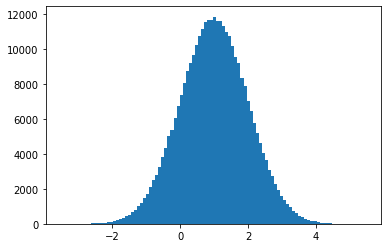

Samples have mean=1.0000311136245728 and std=0.9995415806770325


In [65]:
# It's possible to reuse this state multiple times
cfg = Config(100)
results = run_kernel(cfg, mean=1.0, std=1.0)
plt.hist(results, bins=100)
plt.show()
print("Samples have mean={} and std={}".format(results.mean(), results.std()))


## How to get dynamically allocated shared variables?

In [94]:
@cuda.jit
def myKernel():
   sm = cuda.shared.array(shape=0,dtype=numba.float32)
   sm[0] = 1
   # do stuff
   print("shape of shared memory should match the block size", sm.shape[0], cuda.blockDim.x)
   print("sm[0]=", sm[0])
   print("sm[1]=", sm[1])
   

grid = 1
block = 10
stream = 0
sm_size = block*np.float32().itemsize
print("sm_size = {}".format(sm_size))
# myKernel[grid,block,stream,sm_size](arga)
myKernel[grid,block,stream,sm_size]()

sm_size = 40


/home/jeremy/sara/phoenix-r1/venv/lib/python3.8/site-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


shape of shared memory should match the block size 10 10
shape of shared memory should match the block size 10 10
shape of shared memory should match the block size 10 10
shape of shared memory should match the block size 10 10
shape of shared memory should match the block size 10 10
shape of shared memory should match the block size 10 10
shape of shared memory should match the block size 10 10
shape of shared memory should match the block size 10 10
shape of shared memory should match the block size 10 10
shape of shared memory should match the block size 10 10
sm[0]= 1.000000
sm[0]= 1.000000
sm[0]= 1.000000
sm[0]= 1.000000
sm[0]= 1.000000
sm[0]= 1.000000
sm[0]= 1.000000
sm[0]= 1.000000
sm[0]= 1.000000
sm[0]= 1.000000
sm[1]= 0.000000
sm[1]= 0.000000
sm[1]= 0.000000
sm[1]= 0.000000
sm[1]= 0.000000
sm[1]= 0.000000
sm[1]= 0.000000
sm[1]= 0.000000
sm[1]= 0.000000
sm[1]= 0.000000


## Now clean up MPPI_Numba
* Preinitialize GPU variables (map samples, noise_samples, useq0)
* Take a reference to the TDM_Numba object
* Allow optimization steps performed on GPU as well (avoid copying back and forth)
* Optionally get the solution (and/or samples) from GPU and visualize


In [ ]:
T= 10
dt=0.1
TIMESTEPS = timesteps=int(T/dt)
num_control_rollouts = 1024

class MPPI_Numba(object):

  NUM_CONTROL_ROLLOUTS = num_control_rollouts
  NUM_STEPS = TIMESTEPS
  NUM_GRID_SAMPLES = num_grid_samples


  def __init__(self):
    self.params = None
    self.params_set = False

    # Hold reference to the current linear and angular TDM
    self.lin_tdm = None
    self.ang_tdm = None
    self.tdm_set = False

    # Initialize device variables
    self.noise_samples_d = None
    self.u_cur_d = None
    self.costs_d = None
    self.weights_d = None
    self.rng_states_d = None
    
    self.device_var_initialized = False

    # Sanity checks
    assert self.NUM_STEPS <= 1024, "NUM_STEPS={} current cannot be more than 1024".format(self.NUM_STEPS)


  def is_within_bound(self, v, vbounds):
    return v>=vbounds[0] and v<=vbounds[1]

  def set_params(self, params):
    # Check conditions
    assert self.tdm_set, "TDM must be set before MPPI parameters"
    # angle must be 0~2*np.pi
    assert self.is_within_bound(params['x0'][0], self.lin_tdm.xlimits), "x0[0] is not within xlimits."
    assert self.is_within_bound(params['x0'][1], self.lin_tdm.ylimits), "x0[1] is not within ylimits."
    # assert self.is_within_bound(params['x0'][2], [0, 2*np.pi]), "x0[2] is not in [0,2*pi]"

    self.params = params
    self.params_set = True

  def update_params(self, sub_params):
    # Update a subset of the parameters (e.g., x0, xgoal)
    for key, val in sub_params.items():
      if key in self.params:
        self.params[key] = val

  def set_tdm(self, lin_tdm, ang_tdm):
    self.lin_tdm = lin_tdm
    self.ang_tdm = ang_tdm
    self.tdm_set = True


  def init_device_vars_before_solving(self):
    # noise, sol, 
    if not self.params_set:
      assert False, "Params not set. Cannot initialize GPU memory for noise samples and current control sequence."

    if not self.device_var_initialized:
      self.noise_samples_d = cuda.device_array((self.NUM_CONTROL_ROLLOUTS, self.NUM_STEPS, 2), dtype=np.float32) # to be sampled collaboratively via GPU
      self.costs_d = cuda.device_array((self.NUM_CONTROL_ROLLOUTS), dtype=np.float32)
      self.weights_d = cuda.device_array((self.NUM_CONTROL_ROLLOUTS), dtype=np.float32)
      self.rng_states_d = create_xoroshiro128p_states(self.NUM_CONTROL_ROLLOUTS*self.NUM_STEPS, seed=1)
      self.u_cur_d = cuda.to_device(np.asarray(self.params['u_seq0']).astype(np.float32)) # likely reused
      self.device_var_initialized = True

  def solve(self):
    assert self.params_set, "MPPI parameters are not set"
    assert self.tdm_set, "MPPI has not received TDMs"

    if not self.device_var_initialized:
      print("Device variables not initialized. Cannot run mppi.")
      return
    
    # Move things to GPU
    res_d = np.float32(self.lin_tdm.res) # no need to move int
    xlimits_d = cuda.to_device(self.lin_tdm.padded_xlimits.astype(np.float32))
    ylimits_d = cuda.to_device(self.lin_tdm.padded_ylimits.astype(np.float32))
    vrange_d = cuda.to_device(self.params['vrange'].astype(np.float32))
    wrange_d = cuda.to_device(self.params['wrange'].astype(np.float32))
    xgoal_d = cuda.to_device(self.params['xgoal'].astype(np.float32))
    v_post_rollout_d = np.float32(self.params['v_post_rollout'])
    goal_tolerance_d = np.float32(self.params['goal_tolerance'])
    lambda_weight_d = np.float32(self.params['lambda_weight'])
    u_std_d = cuda.to_device(self.params['u_std'].astype(np.float32))
    cvar_alpha_d = np.float32(self.params['cvar_alpha'])
    x0_d = cuda.to_device(self.params['x0'].astype(np.float32))
    dt_d = np.float32(self.params['dt'])
    
    
    # Sample environment realizations for estimating cvar
    self.lin_tdm.init_device_vars_before_sampling()
    self.ang_tdm.init_device_vars_before_sampling()
    lin_sample_grid_batch_d = self.lin_tdm.sample_grids() # get ref to device samples
    ang_sample_grid_batch_d = self.ang_tdm.sample_grids() # get ref to device samples

    # Optimization loop
    for k in range(self.params['num_opt']):
      # Sample control noise
      self.sample_noise_numba[self.NUM_CONTROL_ROLLOUTS, self.NUM_STEPS](
            self.rng_states_d, u_std_d, self.noise_samples_d)
      
      # Rollout and compute mean or cvar
      self.rollout_numba[self.NUM_CONTROL_ROLLOUTS, self.NUM_GRID_SAMPLES](
        lin_sample_grid_batch_d,
        ang_sample_grid_batch_d,
        self.lin_tdm.bin_values_bounds_d,
        self.ang_tdm.bin_values_bounds_d,
        res_d,
        xlimits_d,
        ylimits_d,
        vrange_d,
        wrange_d,
        xgoal_d,
        v_post_rollout_d,
        goal_tolerance_d,
        lambda_weight_d,
        u_std_d,
        cvar_alpha_d,
        x0_d,
        dt_d,
        self.noise_samples_d,
        self.u_cur_d,
        # results
        self.costs_d
      )

      # Compute cost and update the optimal control on device
      self.update_useq_numba[1, 32](
        lambda_weight_d, 
        self.costs_d, 
        self.noise_samples_d, 
        self.weights_d, 
        vrange_d,
        wrange_d,
        self.u_cur_d
      )

    # return: full control sequence copied from GPU
    return self.u_cur_d.copy_to_host()

  def update_state(self, new_x0, num_steps=1):
    # Shift solver state forward in time
    # Set the current starting position
    # Set the current map based on the pmf?
    # Should be done on GPU
    # Update current sequence of control, 
    pass


  """GPU kernels"""

  @staticmethod
  @cuda.jit(fastmath=True)
  def rollout_numba(
          lin_sample_grid_batch_d,
          ang_sample_grid_batch_d,
          lin_bin_values_bounds_d,
          ang_bin_values_bounds_d,
          res_d, 
          xlimits_d, 
          ylimits_d, 
          vrange_d, 
          wrange_d, 
          xgoal_d, 
          v_post_rollout_d, 
          goal_tolerance_d, 
          lambda_weight_d, 
          u_std_d, 
          cvar_alpha_d, 
          x0_d, 
          dt_d,
          noise_samples_d,
          u_cur_d,
          costs_d):
    """
    Every thread in each block considers different traction grids but the same control sequence.
    Each block produces a single result (reduce a shared list to produce CVaR or mean. Is there a more efficient way to do this?)
    """
    # Get block id and thread id
    bid = cuda.blockIdx.x   # index of block
    tid = cuda.threadIdx.x  # index of thread within a block

    # Create shared array for saving temporary costs
    block_width = cuda.blockDim.x
    thread_cost_shared = cuda.shared.array(num_grid_samples, dtype=numba.float32)
    thread_cost_shared[tid] = 0.0

    # Move control sequence to shared array as well
    timesteps = len(u_cur_d)
    useq_shared = cuda.shared.array((TIMESTEPS, 2), dtype=numba.float32) # can only initialize using constants..
    noise_shared = cuda.shared.array((TIMESTEPS, 2), dtype=numba.float32) # can only initialize using constants..
    
    # Since each thread uses the same sequence, construct in shared memory
    num = math.ceil(timesteps/block_width)
    tstart = min(tid*num, timesteps)
    tend = min(tstart+num, timesteps)
    for i in range(tstart, tend):
      useq_shared[i,0] = u_cur_d[i,0]
      useq_shared[i,1] = u_cur_d[i,1]
      noise_shared[i,0] = noise_samples_d[bid, i,0]
      noise_shared[i,1] = noise_samples_d[bid, i,1]
    
    # Sync before moving on
    cuda.syncthreads()

    # Explicit unicycle update and map lookup
    # From here on we assume grid is properly padded so map lookup remains valid
    height, width = lin_sample_grid_batch_d[tid].shape
    x_curr = cuda.local.array(3, numba.float32)
    for i in range(3): 
      x_curr[i] = x0_d[i]

    goal_reached = False
    goal_tolerance_d2 = goal_tolerance_d*goal_tolerance_d
    dist_to_goal2 = 1e9
    v_nom =v_noisy = w_nom = w_noisy = 0.0

    lin_ratio = 0.01*(lin_bin_values_bounds_d[1]-lin_bin_values_bounds_d[0])
    ang_ratio = 0.01*(ang_bin_values_bounds_d[1]-ang_bin_values_bounds_d[0])

    PI2 = numba.float32(math.pi*2.0)
    
    for t in range(timesteps):
      # Look up the traction parameters from map
      xi = numba.int32((x_curr[0]-xlimits_d[0])//res_d)
      yi = numba.int32((x_curr[1]-ylimits_d[0])//res_d)

      vtraction = lin_bin_values_bounds_d[0] + lin_ratio*lin_sample_grid_batch_d[tid, yi, xi]
      wtraction = ang_bin_values_bounds_d[0] + ang_ratio*ang_sample_grid_batch_d[tid, yi, xi]

      # Nominal noisy control
      v_nom = useq_shared[t, 0] + noise_shared[t, 0]
      w_nom = useq_shared[t, 1] + noise_shared[t, 1]
      v_noisy = max(vrange_d[0], min(vrange_d[1], v_nom))
      w_noisy = max(wrange_d[0], min(wrange_d[1], w_nom))
      
      # Forward simulate
      x_curr[0] += dt*vtraction*v_noisy*math.cos(x_curr[2])
      x_curr[1] += dt*vtraction*v_noisy*math.sin(x_curr[2])
      x_curr[2] += dt*wtraction*w_noisy

      # Clip angle values within [0, 2pi] (Hmm don't think is needed)
      # x_curr[2] = math.fmod(math.fmod(x_curr[2], PI2)+PI2, PI2)

      # Accumulate cost starting at the initial state
      thread_cost_shared[tid]+=dt
      if not goal_reached:
        dist_to_goal2 = (xgoal_d[0]-x_curr[0])**2 + (xgoal_d[1]-x_curr[1])**2
        if dist_to_goal2<= goal_tolerance_d2:
          goal_reached = True
          break
      
    # Accumulate terminal cost 
    if not goal_reached:
      thread_cost_shared[tid] += math.sqrt(dist_to_goal2)/v_post_rollout_d

    # Accumulate the missing stage cost
    for t in range(timesteps):
      thread_cost_shared[tid] += lambda_weight_d*(
              (useq_shared[t,0]/(u_std_d[0]**2))*noise_shared[t,0] + (useq_shared[t,1]/(u_std_d[1]**2))*noise_shared[t, 1])

    # Reudce thread_cost_shared to a single value (mean or CVaR)
    cuda.syncthreads()  # make sure all threads have produced costs

    numel = block_width
    if cvar_alpha_d<1:
      numel = math.ceil(block_width*cvar_alpha_d)
      # --- CVaR requires sorting the elements ---
      # First sort the costs from descending order via parallel bubble sort
      # https://stackoverflow.com/questions/42620649/sorting-algorithm-with-cuda-inside-or-outside-kernels
      for i in range(math.ceil(block_width/2)):
        # Odd
        if (tid%2==0) and ((tid+1)!=block_width):
          if thread_cost_shared[tid+1]>thread_cost_shared[tid]:
            # swap
            temp = thread_cost_shared[tid]
            thread_cost_shared[tid] = thread_cost_shared[tid+1]
            thread_cost_shared[tid+1] = temp
        cuda.syncthreads()
        # Even
        if (tid%2==1) and ((tid+1)!=block_width):
          if thread_cost_shared[tid+1]>thread_cost_shared[tid]:
            # swap
            temp = thread_cost_shared[tid]
            thread_cost_shared[tid] = thread_cost_shared[tid+1]
            thread_cost_shared[tid+1] = temp
        cuda.syncthreads()

    # Average reduction based on quantile (all elements for cvar_alpha_d==1)
    # The mean of the first alpha% will be the CVaR
    numel = math.ceil(block_width*cvar_alpha_d)
    s = 1
    while s < numel:
      if (tid % (2 * s) == 0) and ((tid + s) < numel):
        # Stride by `s` and add
        thread_cost_shared[tid] += thread_cost_shared[tid + s]
      s *= 2
      cuda.syncthreads()

    # After the loop, the zeroth  element contains the sum
    if tid == 0:
      costs_d[bid] = thread_cost_shared[0]/numel

  @staticmethod
  @cuda.jit(fastmath=True)
  def update_useq_numba(
        lambda_weight_d,
        costs_d,
        noise_samples_d,
        weights_d,
        vrange_d,
        wrange_d,
        u_cur_d):
    # Assume the function is invoked as update_useq_numba[1, NUM_THREADS]
    tid = cuda.threadIdx.x
    num_threads = cuda.blockDim.x
    numel = len(noise_samples_d)
    gap = int(math.ceil(numel / num_threads))

    # Find the minimum value via reduction
    starti = min(tid*gap, numel)
    endi = min(starti+gap, numel)
    if starti<numel:
      weights_d[starti] = costs_d[starti]
    for i in range(starti, endi):
      weights_d[starti] = min(weights_d[starti], costs_d[i])
    cuda.syncthreads()

    s = gap
    while s < numel:
      if (starti % (2 * s) == 0) and ((starti + s) < numel):
        # Stride by `s` and add
        weights_d[starti] = min(weights_d[starti], weights_d[starti + s])
      s *= 2
      cuda.syncthreads()

    beta = weights_d[0]
    
    # Compute weight
    for i in range(starti, endi):
      weights_d[i] = math.exp(-1./lambda_weight_d*(costs_d[i]-beta))
    cuda.syncthreads()

    # Normalize
    # Reuse costs_d array
    for i in range(starti, endi):
      costs_d[i] = weights_d[i]
    cuda.syncthreads()
    for i in range(starti+1, endi):
      costs_d[starti] += costs_d[i]
    cuda.syncthreads()
    s = gap
    while s < numel:
      if (starti % (2 * s) == 0) and ((starti + s) < numel):
        # Stride by `s` and add
        costs_d[starti] += costs_d[starti + s]
      s *= 2
      cuda.syncthreads()

    for i in range(starti, endi):
      weights_d[i] /= costs_d[0]
    cuda.syncthreads()
    
    # update the u_cur_d
    timesteps = len(u_cur_d)
    for t in range(timesteps):
      for i in range(starti, endi):
        cuda.atomic.add(u_cur_d, (t, 0), weights_d[i]*noise_samples_d[i, t, 0])
        cuda.atomic.add(u_cur_d, (t, 1), weights_d[i]*noise_samples_d[i, t, 1])
    cuda.syncthreads()

    # Blocks crop the control together
    tgap = int(math.ceil(timesteps / num_threads))
    starti = min(tid*tgap, timesteps)
    endi = min(starti+tgap, timesteps)
    for ti in range(starti, endi):
      u_cur_d[ti, 0] = max(vrange_d[0], min(vrange_d[1], u_cur_d[ti, 0]))
      u_cur_d[ti, 1] = max(wrange_d[0], min(wrange_d[1], u_cur_d[ti, 1]))


  @staticmethod
  @cuda.jit(fastmath=True)
  def update_state_numba():
    # TODO
    pass

  @staticmethod
  @cuda.jit(fastmath=True)
  def sample_noise_numba(rng_states, u_std_d, noise_samples_d):
    # sample_noise_numba[NUM_U_SAMPLES, NUM_THREADS]
    # noise_samples_d.shape is assumed to be (num_rollouts, time_steps, 2)
    # Assume each thread corresponds to one time step
    # For consistency, each block samples a sequence, and threads (not too many) work together over num_steps
    block_id = cuda.blockIdx.x
    thread_id = cuda.threadIdx.x
    abs_thread_id = cuda.grid(1)

    noise_samples_d[block_id, thread_id, 0] = u_std_d[0]*xoroshiro128p_normal_float32(rng_states, abs_thread_id)
    noise_samples_d[block_id, thread_id, 1] = u_std_d[1]*xoroshiro128p_normal_float32(rng_states, abs_thread_id)



In [ ]:

u_seq0 = np.zeros((timesteps, 2), dtype=float)
x0=np.array([0.5, 1.5, 0])
# xgoal= np.array([0.5, 8.5])
xgoal= np.array([8.5, 8.5])

mppi_params = dict(
    # Task specification
    dt=dt,
    x0=x0,
    xgoal=xgoal,
    timesteps=timesteps,
    u_seq0=u_seq0,

    # For risk-aware min time planning
    goal_tolerance=0.5,
    v_post_rollout=0.01,
    cvar_alpha=0.99, # use the mean if cvar_alpha=1.0

    # Hyper parameters
    lambda_weight=1.0,
    num_opt=1,

    # Control and sample specification
    u_std=np.array([2.0, 2.0]),
    vrange = np.array([0, 3]), 
    wrange=np.array([-np.pi, np.pi]),
)


mppi_planner = MPPI_Numba()
mppi_planner.set_tdm(lin_tdm, ang_tdm)
mppi_planner.set_params(mppi_params)
mppi_planner.init_device_vars_before_solving()
useq = mppi_planner.solve()
%timeit useq = mppi_planner.solve()

In [ ]:
fig, ax = plt.subplots()
ax.plot(useq[:,0], label='v')
ax.plot(useq[:,1], label='w')
ax.legend()
plt.show()

lin_tdm_vis = TDM_Visualizer(lin_tdm)
fig, ax = lin_tdm_vis.draw(figsize=(5, 5))
ax.plot([x0[0]], [x0[1]], 'ro', markersize=10, label="Start")
c1 = plt.Circle(xgoal, mppi_params['goal_tolerance'], color='r', fill=False, label="Goal")
ax.add_patch(c1)

# Rollout over sampled environments
xhist = np.zeros((timesteps+1, 3))
xhist[0] = x0
for t in range(timesteps):
  xhist[t+1, 0] = xhist[t, 0] + dt*np.cos(xhist[t, 2])*useq[t,0]
  xhist[t+1, 1] = xhist[t, 1] + dt*np.sin(xhist[t, 2])*useq[t,0]
  xhist[t+1, 2] = xhist[t, 2] + dt*useq[t,1]

ax.plot(xhist[:,0], xhist[:,1])

ax.plot()

### Closed-loop performance

Given a sampled environment, do receiding horizon planning based on the sampled dynamics.
* Color the traversed part as solid red
* Color the future parts (over X presampled envs) of the optimal solution
  * Do this in GPU as well? (Use already sampled batch on GPU, copy back a subset of the state trajectories)

In [ ]:
# For now, do in jupyter notebook by visualizing multiple frames of the problem

# Fixed a sampled environment

# Loop
# Solve
# Update state
# Update MPPI state
# Update Visualization
# Goal check

# Print performance info